In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
senate_polls_url = 'https://projects.fivethirtyeight.com/polls/data/senate_polls_historical.csv'
df = pd.read_csv(senate_polls_url)
df.to_csv("../Data/raw/senate_polls_historical.csv")

In [3]:
df = pd.read_csv("../Data/raw/senate_polls_historical.csv")
df_state = pd.read_csv("../Data/clean/state_code.csv")

In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

df = df.query("stage == 'general'")
df = df.query("election_date == '11/8/22'")

df['date'] = df.median_date

df['week'] = (df['date'] - pd.Timestamp('2022-11-08')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2022-11-08')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()
df = df.query("date >= '2022-01-01'")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/3239854908.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/3239854908.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [5]:
#Drop Alaska since there's no R in the race
df = df.query("state != 'AK'")

#Seperate Oklahoma's special election
df.loc[(df['state'] == 'OK') & (df['answer'].isin(['Mullin', 'K. Horn'])),'state'] = 'OK-S'

#Make independent 'Democrats'
df.loc[(df['state'] == 'UT') & (df['answer'] == 'McMullin'), 'party'] = 'DEM'

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [6]:
senate_races = {
'OK-S': ['M. Horn', 'Lankford'],
'AL': ['Boyd', 'Britt'],
'AK': ['Murkowski', 'Tshibaka'],
'AZ': ['Kelly', 'Masters'],
'AR': ['James', 'Boozman'],
'CA': ['Padilla', 'Meuser'],
'CO': ['Bennet', "O'Dea"],
'CT': ['Blumenthal', 'Levy'],
'FL': ['Demings', 'Rubio'],
'GA': ['Warnock', 'Walker'],
'HI': ['Schatz', 'McDermott'],
'ID': ['Roth', 'Crapo'],
'IL': ['Duckworth', 'Salvi'],
'IN': ['McDermott', 'Young'],
'IA': ['Franken', 'Grassley'],
'KS': ['Holland', 'Moran'],
'KY': ['Booker', 'Paul'],
'LA': ['Chambers', 'Kennedy'],
'MD': ['Van Hollen', 'Chaffee'],
'MO': ['Busch Valentine', 'Schmitt'],
'NV': ['Cortez Masto', 'Laxalt'],
'NH': ['Hassan', 'Bolduc'],
'NY': ['Schumer', 'Pinion'],
'NC': ['Beasley', 'Budd'],
'ND': ['Christiansen', 'Hoeven'],
'OH': ['Ryan', 'Vance'],
'OK': ['M. Horn', 'Lankford'],
'OR': ['Wyden', 'Perkins'],
'PA': ['Fetterman', 'Oz'],
'SC': ['Matthews', 'Scott'],
'SD': ['Bengs', 'Thune'],
'UT': ['McMullin', 'Lee'],
'VT': ['Welch', 'Malloy'],
'WA': ['Murray', 'Smiley'],
'WI': ['Barnes', 'Johnson'],
}

df = df.loc[df.apply(lambda row: row['answer'] in senate_races.get(row['state'], []), axis=1)]

In [7]:
df_count = df.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df2 = df_polls.merge(df_count)
df2 = df2.rename(columns={'REP':'GOP'})

df2[['DEM', 'GOP']] = df2[['DEM', 'GOP']].div(100)

In [8]:
df = df2
df = df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1088463050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['obs_id'] = range(len(df))
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1088463050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OTHER'] = 1 - (df['DEM'] + df['GOP'])


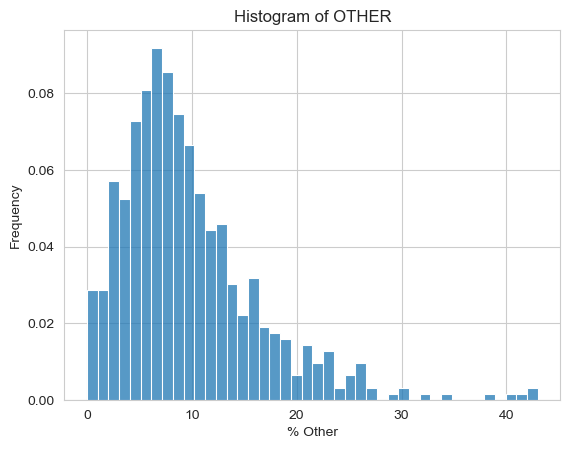

In [9]:
bin_width = 1
max_value = (100 * df['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Histogram of OTHER')
plt.show()

In [10]:
df = df.query("OTHER > 0")

In [11]:
df[['DEM', 'GOP']].describe()

,DEM,GOP
count,619.000000,619.000000
mean,0.455389,0.444268
std,0.059876,0.056002
min,0.190000,0.260000
25%,0.433000,0.410000
50%,0.460000,0.452000
75%,0.490000,0.480000
max,0.630000,0.615000


In [12]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(20).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

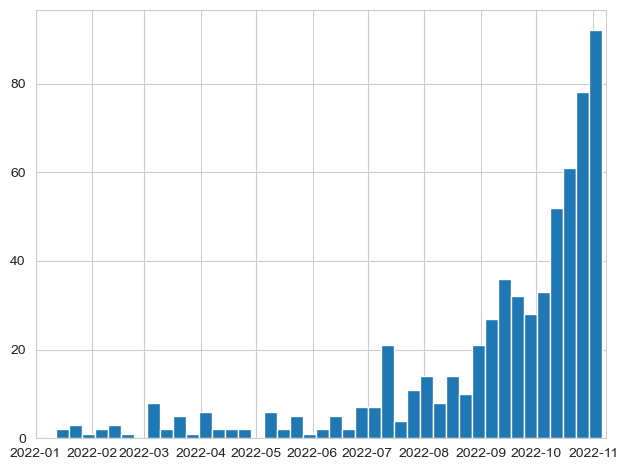

In [13]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))

plt.tight_layout()
plt.show()

In [14]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,IVR/Online Panel/Text-to-Web,IVR/Live Phone/Text/Online Panel/Email,Live Phone/Text-to-Web,IVR/Text,Online Panel/Online Ad,Text,Online Panel/Text-to-Web,IVR/Text-to-Web
pollster,,,,,,,,,,,
All,619,135,128,43,37,33,22,20,19,19,16
Center Street PAC,52,52,0,0,0,0,0,0,0,0,0
Emerson,47,0,0,24,0,0,0,0,0,0,2
Trafalgar Group,37,0,0,0,37,0,0,0,0,0,0
Data for Progress,26,0,0,0,0,0,0,0,0,17,0
Cygnal,24,0,0,12,0,6,0,0,0,0,5
InsiderAdvantage,19,0,0,0,0,0,0,0,17,0,0
Civiqs,18,0,0,0,0,0,0,18,0,0,0
SurveyUSA,15,15,0,0,0,0,0,0,0,0,0


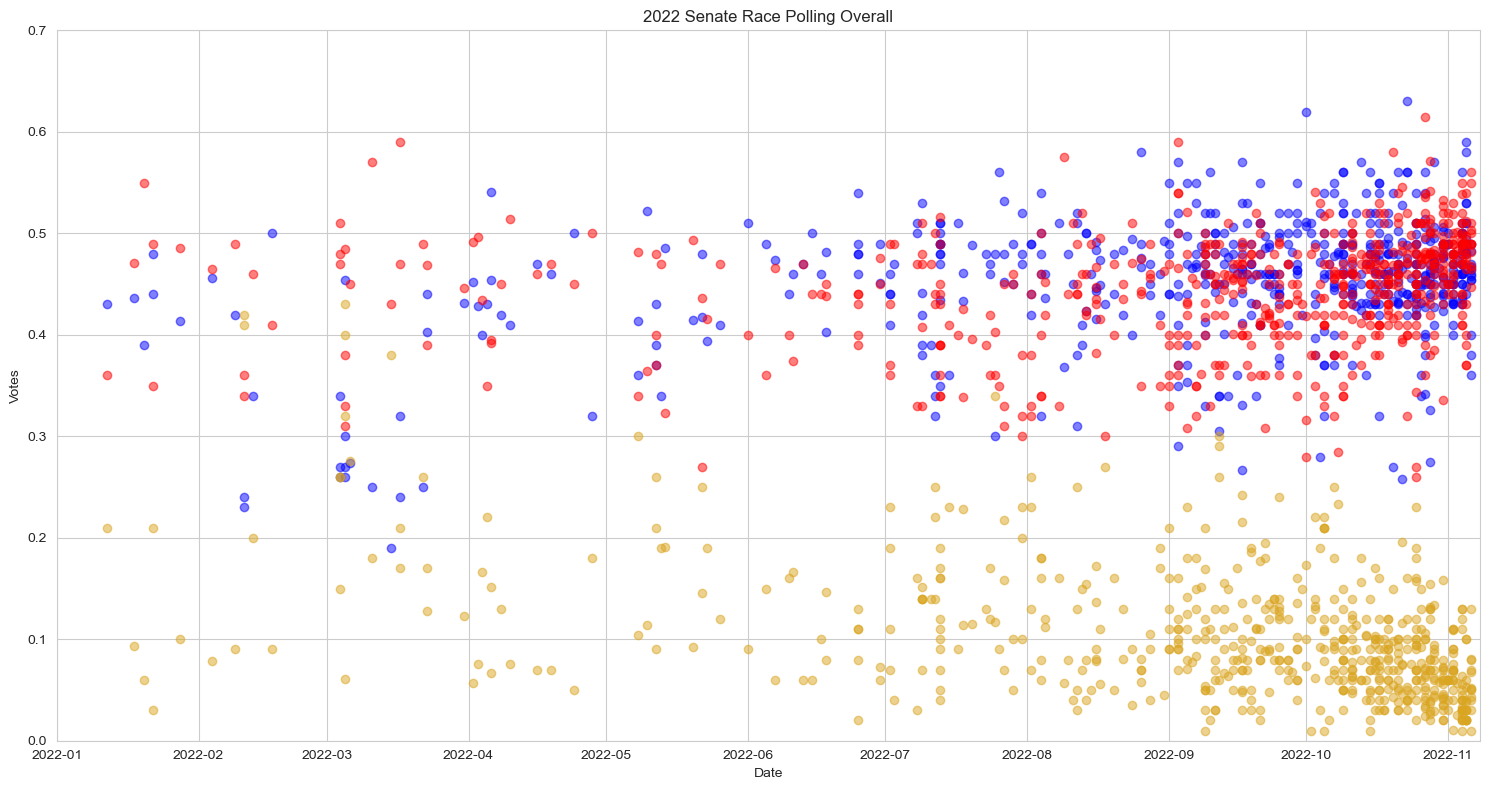

In [15]:
dem_votes = df["DEM"].values
gop_votes = df["GOP"].values
oth_votes = df["OTHER"].values

dates = df.set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Democrat")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Republican")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.7)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2022 Senate Race Polling Overall')

events = [
            (dt.datetime(2022, 11, 8), 'Election Day')
         ]

plt.tight_layout()
plt.show()

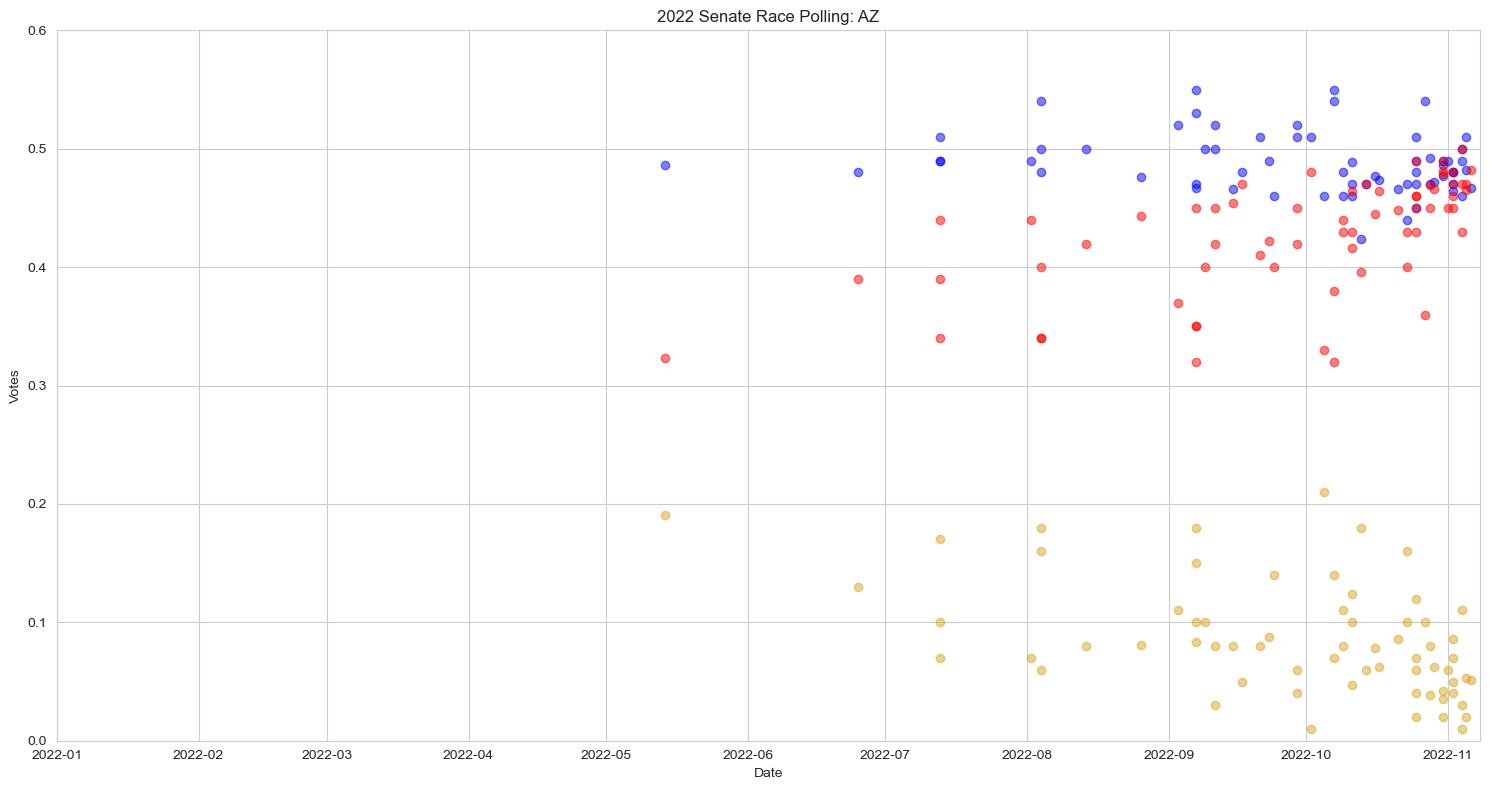

In [16]:
graph_state = 'AZ'

dem_votes = df.query(f"state == '{graph_state}'")["DEM"].values
gop_votes = df.query(f"state == '{graph_state}'")["GOP"].values
oth_votes = df.query(f"state == '{graph_state}'")["OTHER"].values

dates = df.query(f"state == '{graph_state}'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Democrat")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Republican")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"2022 Senate Race Polling: {graph_state}")

events = [
            (dt.datetime(2022, 11, 8), 'Election Day')
         ]

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '30-Day Rolling Polling Mean: AZ')

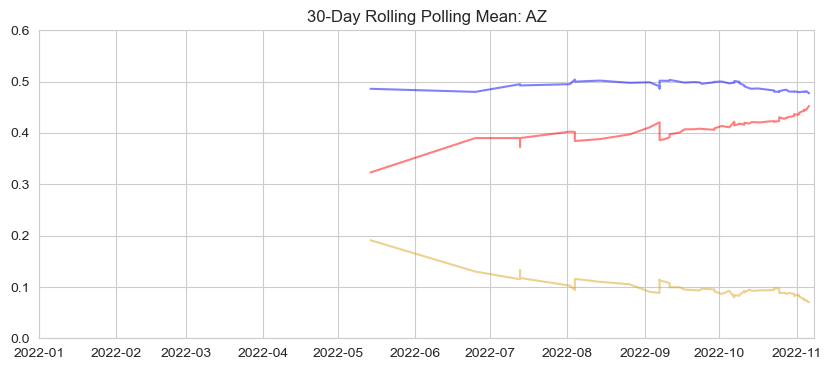

In [17]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Mean: {graph_state}")

Text(0.5, 1.0, '30-Day Rolling Polling Standard Deviation: AZ')

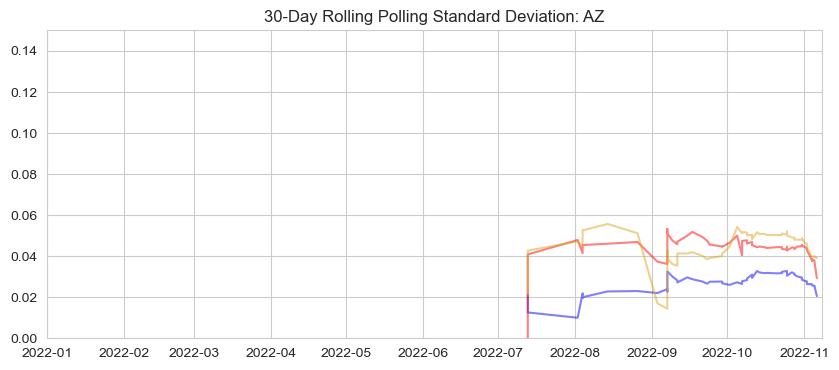

In [18]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Standard Deviation: {graph_state}")

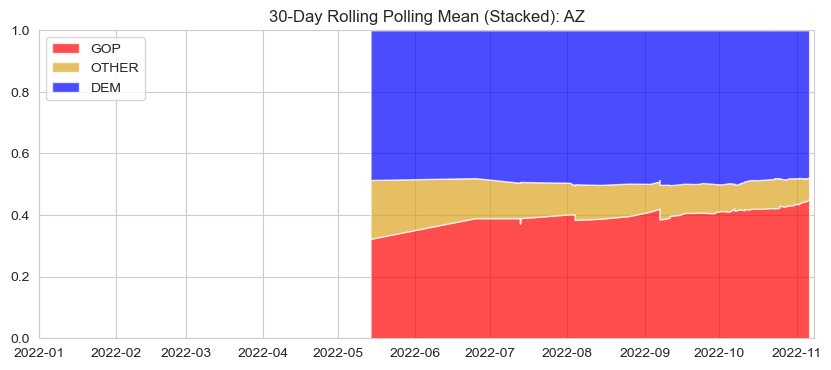

In [19]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Mean (Stacked): {graph_state}")
ax.legend(loc='upper left')

plt.show()

In [20]:
df.query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.431667,0.465333
IVR/Text,0.466864,0.429091
Live Phone,0.445297,0.446930
Live Phone/Online Panel,0.450313,0.447625
Online Panel,0.446883,0.415436
Probability Panel,0.520000,0.407500
Text-to-Web/Online Ad,0.454167,0.448333


In [21]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [22]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,81629,165305,1250,Trafalgar Group,IVR/Live Phone/Text/Online Panel/Email,AZ,lv,1094.0,2022,...,0.48,0,0.05,-0.02,0.48,0.47,-0.01,0.00,-0.00,-0.01
1,1,81775,166099,1250,Trafalgar Group,IVR/Live Phone/Text/Online Panel/Email,NV,lv,1089.0,2022,...,0.50,1,0.04,-0.05,0.48,0.47,-0.01,0.03,-0.01,-0.04
2,2,81778,166100,1528,AtlasIntel,Online Ad,GA,a,905.0,2022,...,0.46,2,0.08,-0.01,0.48,0.47,-0.01,-0.01,-0.01,-0.00
3,3,81778,166101,1528,AtlasIntel,Online Ad,GA,lv,791.0,2022,...,0.49,3,0.05,-0.03,0.48,0.47,-0.01,0.01,-0.01,-0.02
4,6,81579,165126,262,Landmark Communications,Live Phone/Online Panel,GA,lv,1214.0,2022,...,0.47,6,0.07,-0.00,0.48,0.47,-0.01,-0.01,-0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,673,78372,152350,1293,OH Predictive Insights / MBQF,Online Panel,NV,rv,755.0,2022,...,0.35,626,0.21,0.09,0.47,0.44,-0.03,-0.12,0.00,0.12
615,676,78339,152178,396,Quinnipiac,Live Phone,GA,rv,1702.0,2022,...,0.49,627,0.03,-0.01,0.47,0.44,-0.03,0.02,0.04,0.02
616,677,78346,152209,847,U. Georgia SPIA,Live Phone,GA,rv,872.0,2022,...,0.47,628,0.09,-0.04,0.47,0.44,-0.03,0.01,-0.00,-0.01
617,679,78350,152240,289,Mason-Dixon,Live Phone,KY,rv,625.0,2022,...,0.55,629,0.06,-0.16,0.47,0.44,-0.03,0.08,-0.05,-0.13


In [23]:
x_res = np.maximum(df.margin.max(), df.margin.min() * -1)

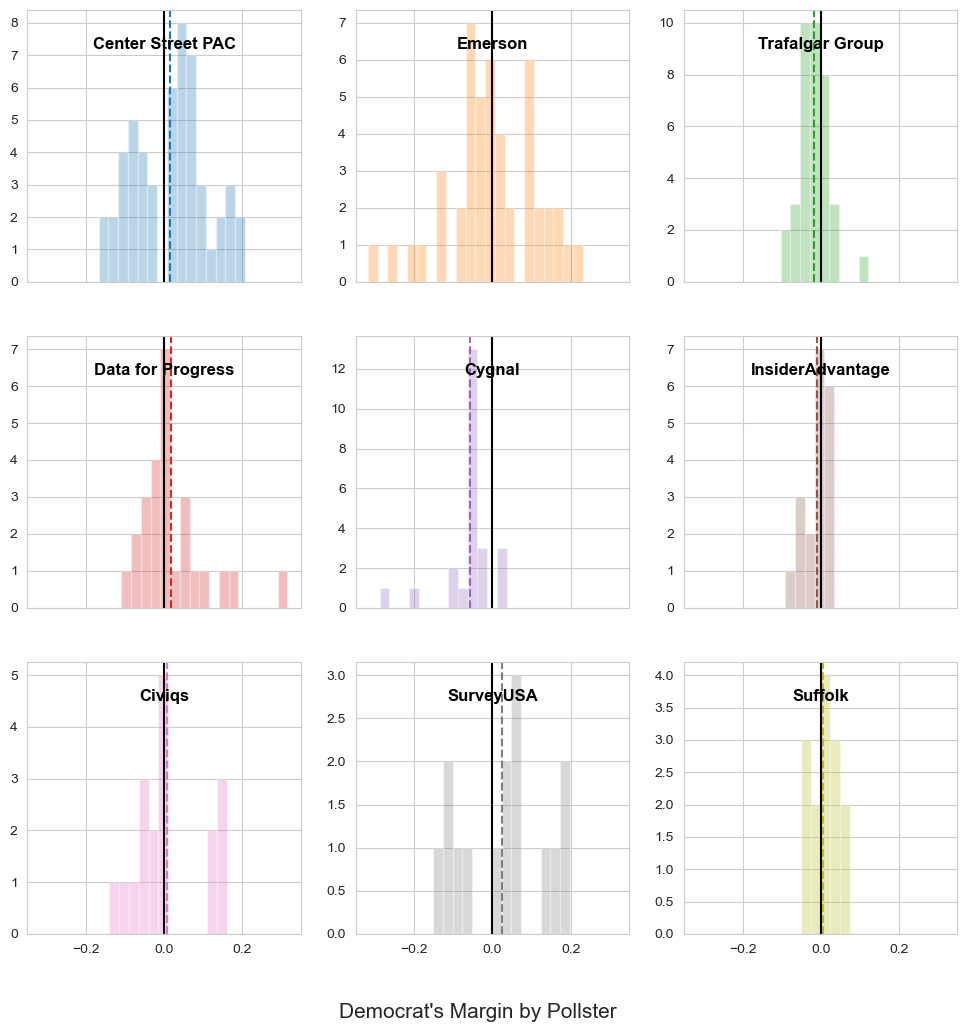

In [24]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

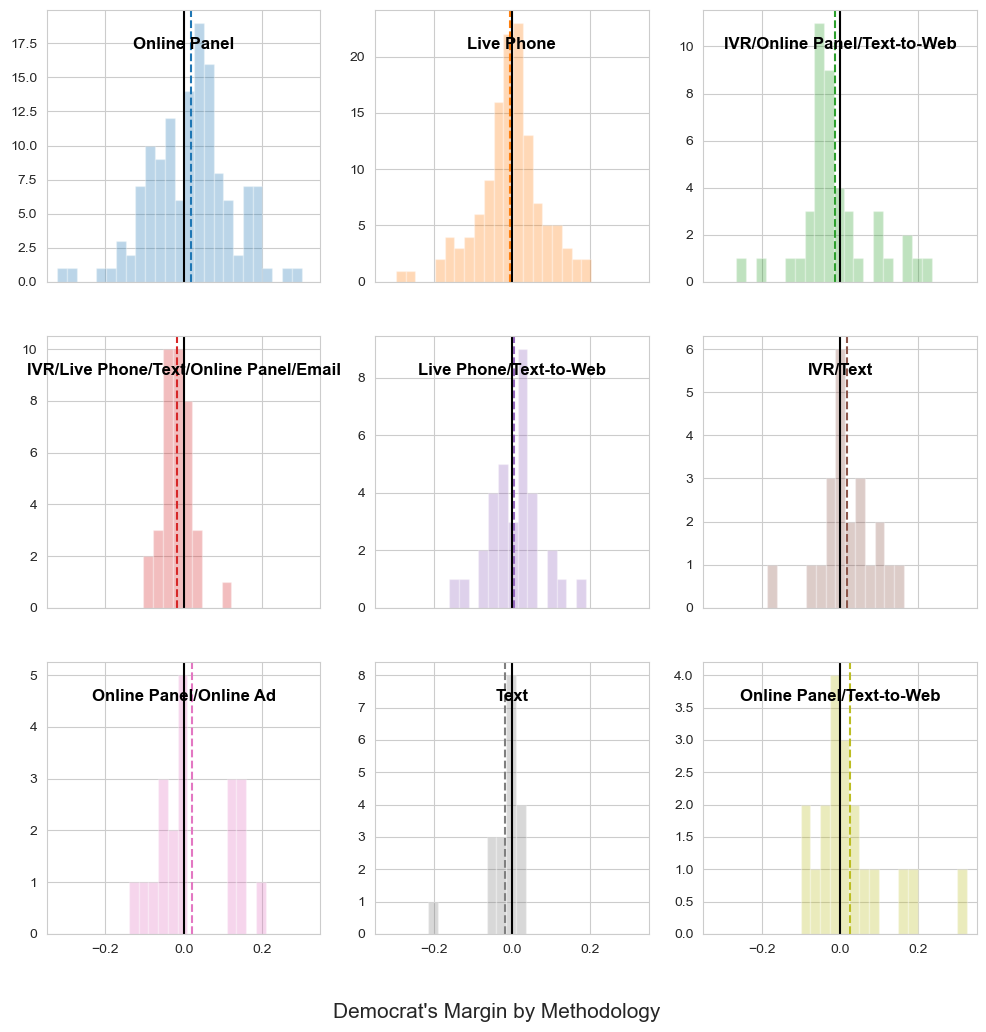

In [25]:
METHOD_VALS = {
    method: df[df["methodology"] == method]["diff_margin"].values
    for method in list(METHODS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), METHOD_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

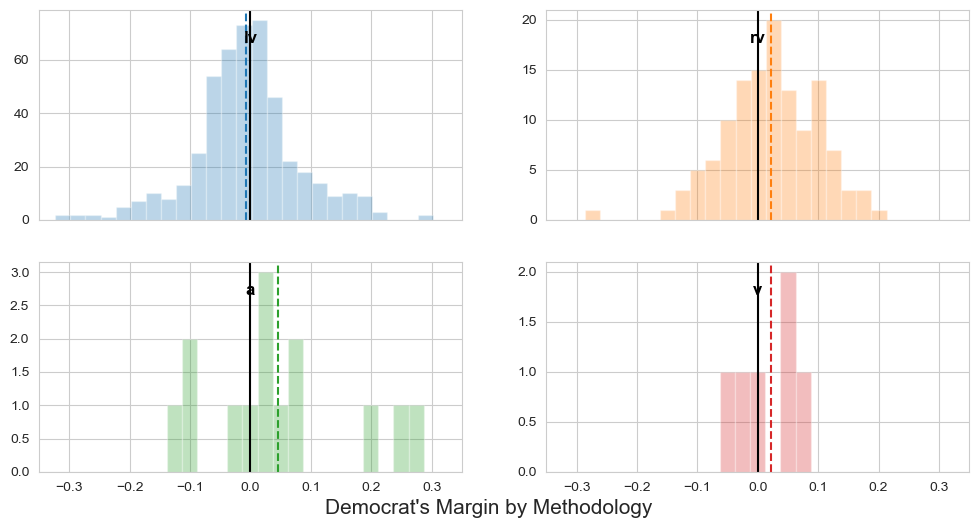

In [26]:
POPULATIONS_VALS = {
    population: df[df["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

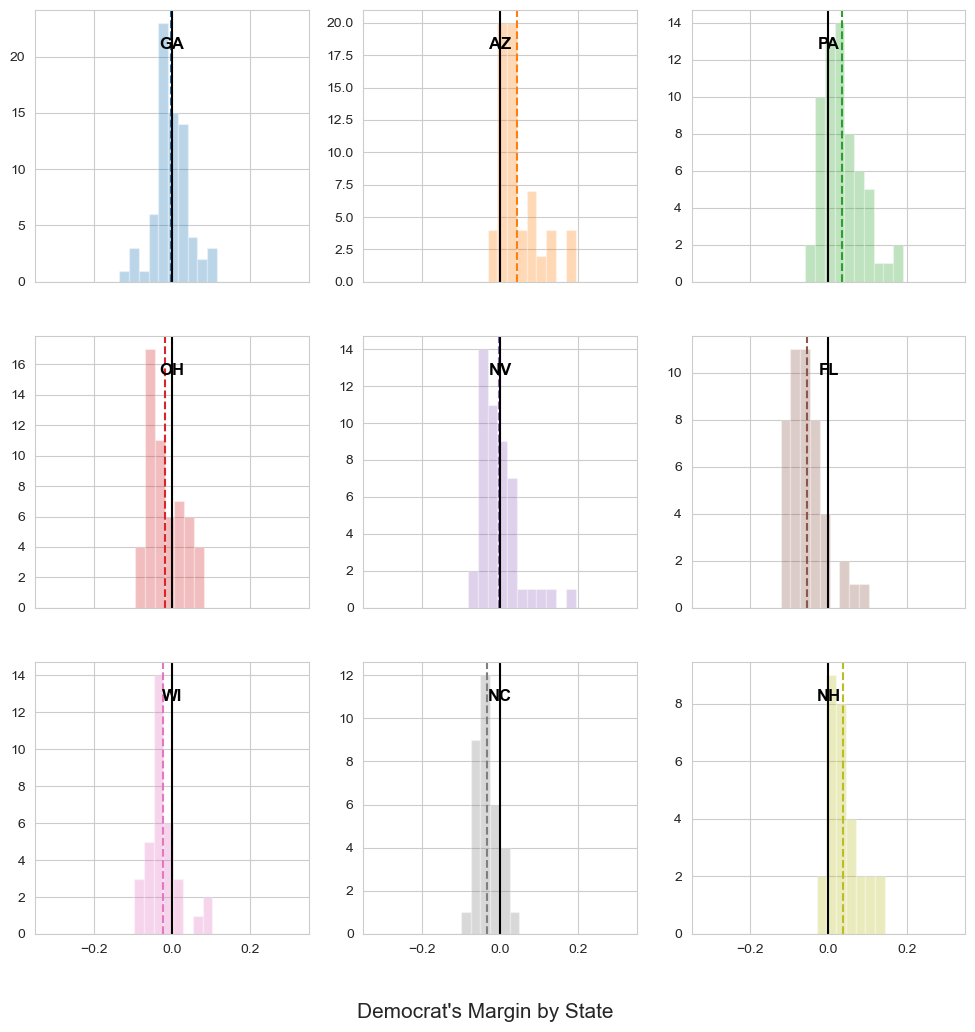

In [27]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (state, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, state, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by State", ha='center', fontsize=15)

# Show the plot
plt.show()

In [28]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [29]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, 1, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95, max_treedepth=15), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 633 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


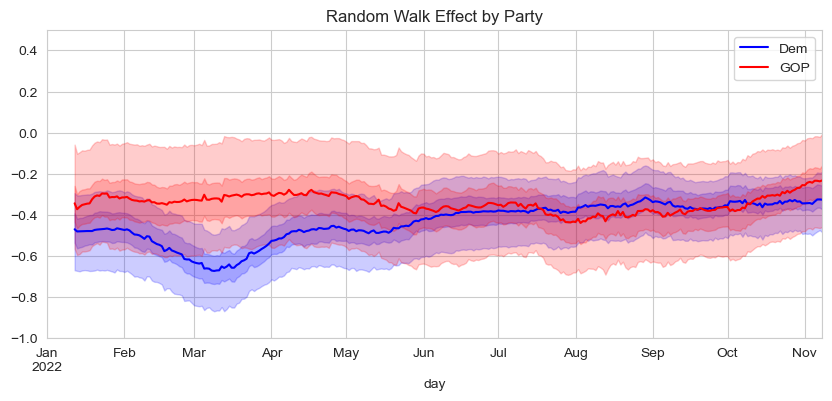

In [70]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.date.min(), end='2022-11-08')

for party in ['dem', 'gop', 'oth']:
    rw[f"{party}_50"] = idata.posterior[f"{party}_day_effect"].median(dim=["chain", "draw"]).values * idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_03",f"{party}_97"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.94)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_25",f"{party}_75"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.50)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values

rw = rw.set_index('day')

rolling_mean = (
    rw
    .rolling(window='7D')
    .mean()
)

fig, ax = plt.subplots(figsize=(10, 4))

for party, color, abb in [('dem', 'blue', 'Dem'), ('gop', 'red', 'GOP')]:
    
    rolling_mean[f"{party}_50"].plot(color=f"{color}", label=f'{abb}')
    plt.fill_between(rw.index, rolling_mean[f"{party}_03"].ffill(), rolling_mean[f"{party}_97"].ffill(), color=f"{color}", alpha=0.2)
    plt.fill_between(rw.index, rolling_mean[f"{party}_25"].ffill(), rolling_mean[f"{party}_75"].ffill(), color=f"{color}", alpha=0.2)

ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylim(-1,.5)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

In [71]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [72]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT")# +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Beacon/Shaw") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist")
    ).values / 2
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2)
        #+
        #idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    )#/2
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"]

In [73]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-18]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            polling_error = 0 if state == 'US' else 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel()
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                polling_error +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.05 if party == 'gop' else 0) # 1% swing towards GOP
                #+ (.05 if party == 'dem' else 0) # 1% swing towards DEM
                )  
            ).to_numpy()

        # Adjust the 'oth' results and sum the total
        day_results[f"{state}_dem"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_gop"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_oth"] /= 2

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 301/301 [00:16<00:00, 18.60it/s]


In [74]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2022-11-08')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

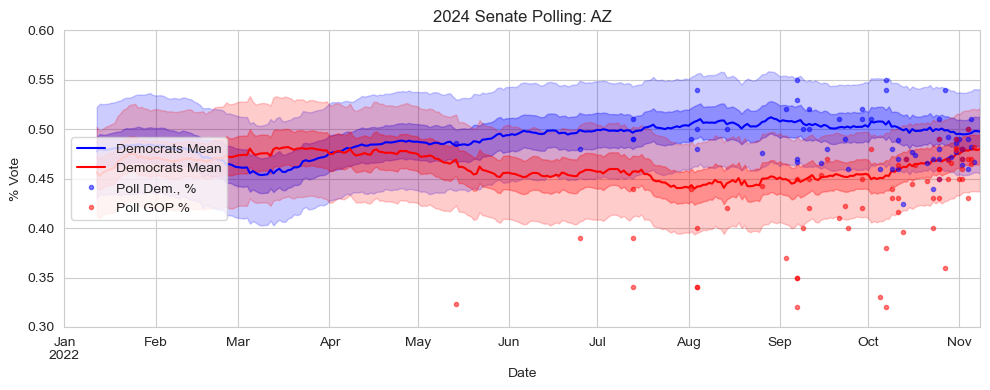

In [75]:
graph_state = 'AZ'

fig, ax = plt.subplots(figsize=(10, 4))

df_day_mean[f'{graph_state}_dem'].rolling(window='7D').mean().plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f'{graph_state}_dem'].rolling(window='7D').mean().ffill(), df_day_97[f'{graph_state}_dem'].rolling(window='7D').mean().ffill(), color='blue', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f'{graph_state}_dem'].rolling(window='7D').mean().ffill(), df_day_75[f'{graph_state}_dem'].rolling(window='7D').mean().ffill(), color='blue', alpha=0.3)

df_day_mean[f'{graph_state}_gop'].rolling(window='7D').mean().plot(color='red', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f'{graph_state}_gop'].rolling(window='7D').mean().ffill(), df_day_97[f'{graph_state}_gop'].rolling(window='7D').mean().ffill(), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f'{graph_state}_gop'].rolling(window='7D').mean().ffill(), df_day_75[f'{graph_state}_gop'].rolling(window='7D').mean().ffill(), color='red', alpha=0.3)

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0.3,.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))
ax.set_title(f'2024 Senate Polling: {graph_state}')

events = [
            (dt.datetime(2022, 11, 8), 'Election Day'),
         ]

plt.tight_layout()
plt.savefig(f"senate_{graph_state}.png")

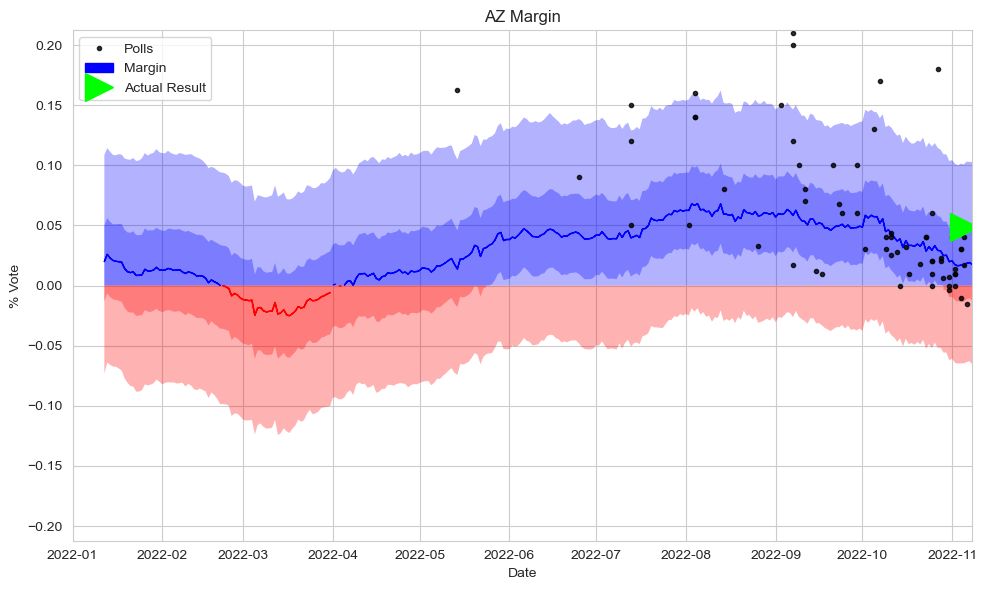

In [76]:
graph_state = 'AZ'

# Assuming df_day_mean, df_day_97, df_day_03, df_day_75, and df_day_25 are DataFrames
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the rolling means for each DataFrame and ensure no NaNs
mean_rolling = df_day_mean[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()

votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"] - df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

ax.plot(votes.index, votes, "o", alpha=.8, markersize=3, color='black', label="Polls")

# Plot 94% HDI

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

ax.plot(dt.datetime(2022, 11, 5), .0488, ">", markersize=20, color='lime', alpha=1, label="Actual Result")

# Set axis limits and labels
y_res = np.maximum((min(hdi_03_rolling)-.05)*-1, max(hdi_97_rolling)+.05)
ax.set_ylim(-y_res, y_res)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))  # Fix xlim parenthesis

ax.set_title(f'{graph_state} Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()

plt.tight_layout()
plt.savefig(f"{graph_state}_senate_margin.png")

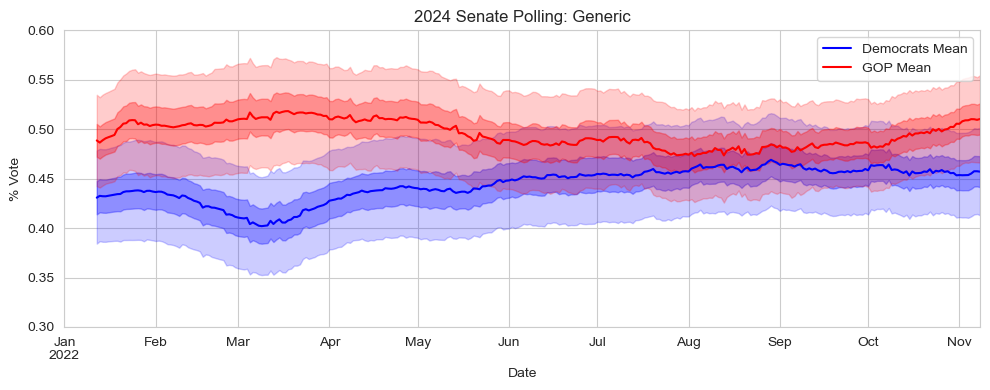

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))

df_day_mean.filter(regex='_dem$').mean(axis=1).rolling(window='7D').mean().plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03.filter(regex='_dem$').mean(axis=1).rolling(window='7D').mean().ffill(), df_day_97.filter(regex='_dem$').mean(axis=1).rolling(window='7D').mean().ffill(), color='blue', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25.filter(regex='_dem$').mean(axis=1).rolling(window='7D').mean().ffill(), df_day_75.filter(regex='_dem$').mean(axis=1).rolling(window='7D').mean().ffill(), color='blue', alpha=0.3)

df_day_mean.filter(regex='gop$').mean(axis=1).rolling(window='7D').mean().plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03.filter(regex='gop$').mean(axis=1).rolling(window='7D').mean().ffill(), df_day_97.filter(regex='gop$').mean(axis=1).rolling(window='7D').mean().ffill(), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25.filter(regex='gop$').mean(axis=1).rolling(window='7D').mean().ffill(), df_day_75.filter(regex='gop$').mean(axis=1).rolling(window='7D').mean().ffill(), color='red', alpha=0.3)

# Set limits and labels
ax.set_ylim(0.3,0.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
ax.set_title(f'2024 Senate Polling: Generic')

plt.tight_layout()
plt.savefig(f"senate_generic.png")

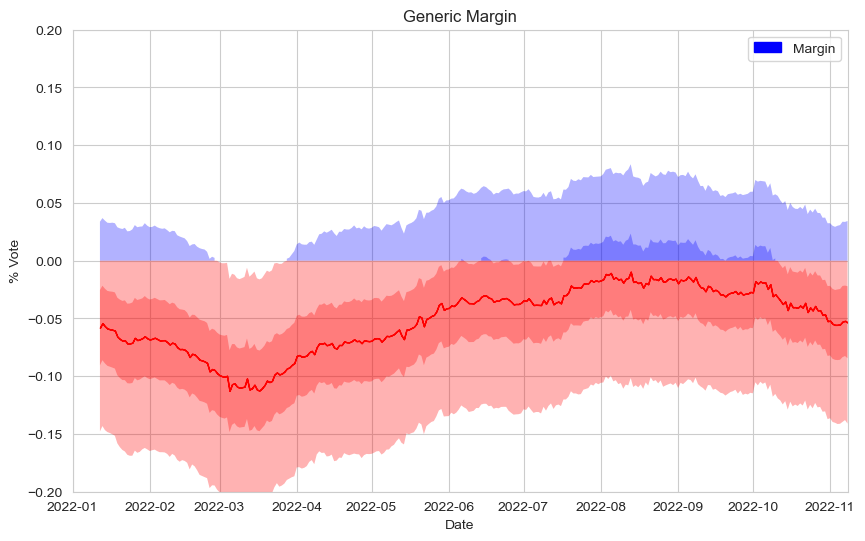

In [78]:
# Assuming df_day_mean, df_day_97, df_day_03, df_day_75, and df_day_25 are DataFrames
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the rolling means for each DataFrame and ensure no NaNs
mean_rolling = df_day_mean.filter(regex='_margin$').mean(axis=1).rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03.filter(regex='_margin$').mean(axis=1).rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97.filter(regex='_margin$').mean(axis=1).rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25.filter(regex='_margin$').mean(axis=1).rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75.filter(regex='_margin$').mean(axis=1).rolling(window='7D').mean().ffill()

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

# Set axis limits and labels
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))  # Fix xlim parenthesis

ax.set_title('Generic Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1773831237.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=1, label='Mean HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1773831237.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin

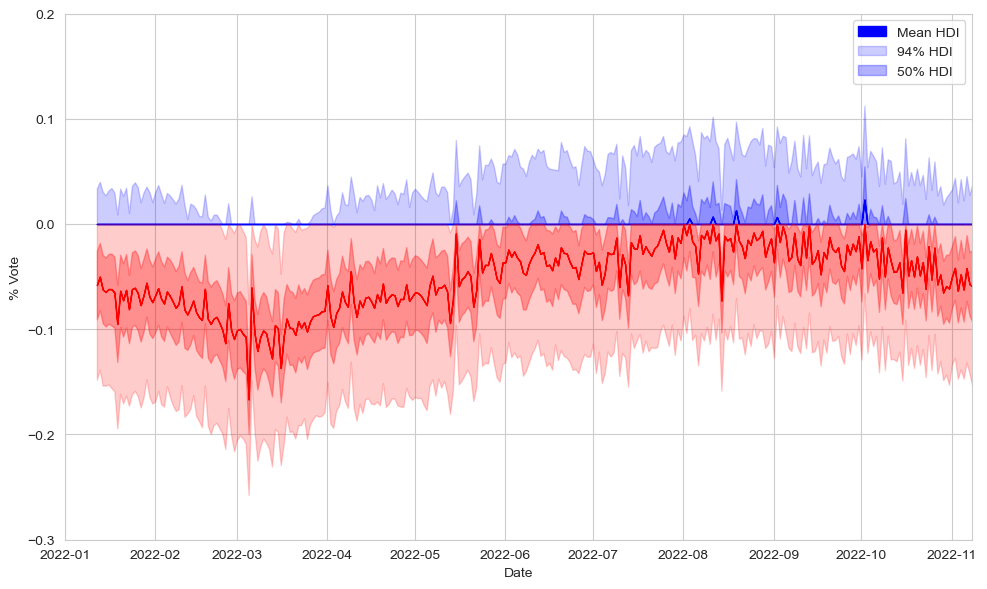

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=1, label='Mean HDI')
plt.fill_between(df_day_97.index, np.maximum(df_day_03.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_97.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=0.2, label='94% HDI')
plt.fill_between(df_day_75.index, np.maximum(df_day_25.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_75.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=0.3, label='50% HDI')
plt.fill_between(df_day_mean.index, np.minimum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=1)
plt.fill_between(df_day_97.index, np.minimum(df_day_03.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_97.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, np.minimum(df_day_25.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_75.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=0.3)

# Set limits and labels
ax.set_ylim(-0.3,0.2)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8) #datetime.datetime.today()
           )
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

plt.tight_layout()
plt.savefig('past_three_years.png')

In [80]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [81]:
races = ['OK-S','AL','AK','AZ','AR','CA','CO','CT','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','MD','MO','NV','NH','NY','NC','ND','OH','OK','OR','PA','SC','SD','UT','VT','WA','WI']

pd.Series(races)[~pd.Series(races).isin(df['state'])]

0     OK-S
2       AK
10      HI
11      ID
17      LA
24      ND
dtype: object

In [82]:
df_winner['OK-S'] = 'gop'
df_winner['HI'] = 'dem'
df_winner['ID'] = 'gop'
df_winner['LA'] = 'gop'
df_winner['ND'] = 'gop'

df_winner['AK'] = 'gop' #Alaska is both R

state_order = df_state['state_code'].to_list

In [83]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [84]:
df_senate = pd.DataFrame()
df_senate['dem'] = 34 + df_winner_dem.sum(axis=1)
df_senate['gop'] = 29 + df_winner_gop.sum(axis=1)
df_senate['dem_senate'] = np.where(df_senate['dem'] >= 51, 1, 0)
df_senate['gop_senate'] = np.where(df_senate['gop'] >= 51, 1, 0)
df_senate['tie_senate'] = np.where(df_senate['dem'] == 50, 1, 0)

In [85]:
# Calculate the total number of rows
total_rows = len(df_senate)

# Calculate the number of rows greater than, equal to, and lower than 50
greater_than_50 = len(df_senate[df_senate['dem'] > 50])
equal_to_50 = len(df_senate[df_senate['dem'] == 50])
lower_than_50 = len(df_senate[df_senate['dem'] < 50])

# Calculate the percentages
percent_greater_than_50 = (greater_than_50 / total_rows) * 100
percent_equal_to_50 = (equal_to_50 / total_rows) * 100
percent_lower_than_50 = (lower_than_50 / total_rows) * 100

percent_greater_than_50, percent_equal_to_50, percent_lower_than_50

(3.9, 4.3999999999999995, 91.7)

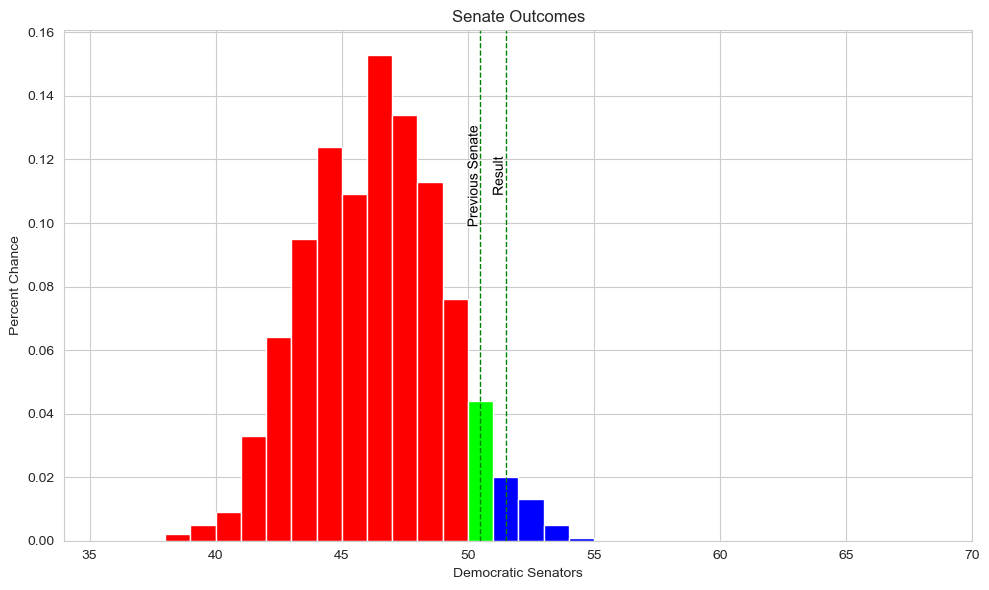

In [86]:
plt.figure(figsize=(10, 6))

bins = list(range(34, 50, 1)) + [50] + list(range(51, 71, 1))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_senate['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 50:
        patch.set_facecolor('red')
    elif x > 50:
        patch.set_facecolor('blue')
    elif x == 50:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
plt.title('Senate Outcomes')
plt.xlabel('Democratic Senators')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (50.5, 'Previous Senate'),
    (51.5, 'Result'),
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [87]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [88]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [89]:
print("Safe D: ")
print(df_win_pct.query("dem >= .98").index.sort_values().values)
print("Likely D: ")
print(df_win_pct.query("(dem < .98) and (dem >= .75)").index.sort_values().values)
print("Leans D: ")
print(df_win_pct.query("(dem < .75) and (dem >= .6)").index.sort_values().values)
print("Tilt D: ")
print(df_win_pct.query("(dem < .6) and (dem >= .5)").index.sort_values().values)
print("Tilt R: ")
print(df_win_pct.query("(gop < .6) and (gop >= .5)").index.sort_values().values)
print("Leans R: ")
print(df_win_pct.query("(gop < .75) and (gop >= .6)").index.sort_values().values)
print("Likely R: ")
print(df_win_pct.query("(gop < .98) and (gop >= .75)").index.sort_values().values)
print("Safe R: ")
print(df_win_pct.query("gop >= .98").index.sort_values().values)

Safe D: 
['CA' 'HI' 'IL' 'NY' 'OR' 'VT']
Likely D: 
['CO' 'CT']
Leans D: 
['AZ' 'MD' 'WA']
Tilt D: 
['NH']
Tilt R: 
['PA']
Leans R: 
['GA']
Likely R: 
['NC' 'NV' 'OH' 'WI']
Safe R: 
['AK' 'AL' 'AR' 'FL' 'IA' 'ID' 'IN' 'KS' 'KY' 'LA' 'MO' 'ND' 'OK' 'OK-S'
 'SC' 'SD' 'UT']


In [90]:
df_win_pct.query("(dem > .02) and (dem < .98)").sort_values('dem')

,dem,gop
OH,0.081,0.919
NC,0.093,0.907
WI,0.137,0.863
NV,0.240,0.760
GA,0.333,0.667
PA,0.489,0.511
NH,0.587,0.413
AZ,0.607,0.393
MD,0.704,0.296
WA,0.749,0.251


In [91]:
df_2022 = pd.read_csv("../Data/clean/2022_senate_results.csv")

In [92]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).quantile(0.50)
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin = df_margin * 1.5

df_margin['state_code'] = df_dem.columns.values
df_margin = df_margin.merge(df_win_pct,left_index=True, right_index=True)
df_margin = df_margin.merge(df_2022[['margin','State']].set_index('State'),left_index=True, right_index=True)

df_margin['electoral_2024'] = 10

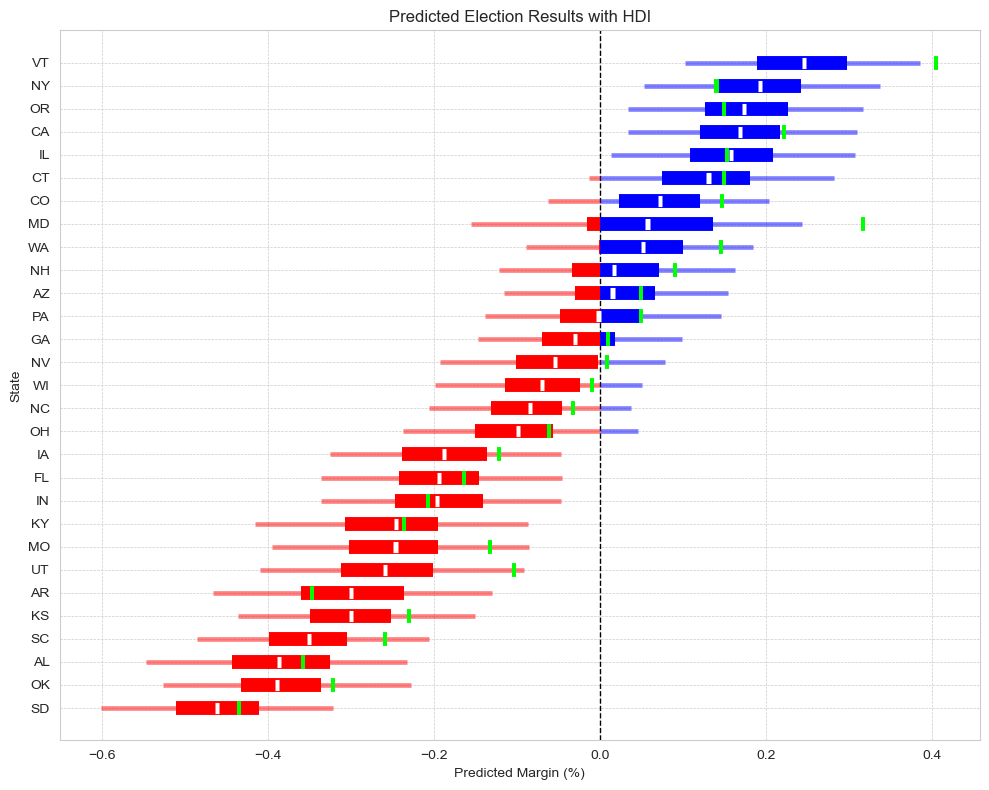

In [93]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 8))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['electoral_2024'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

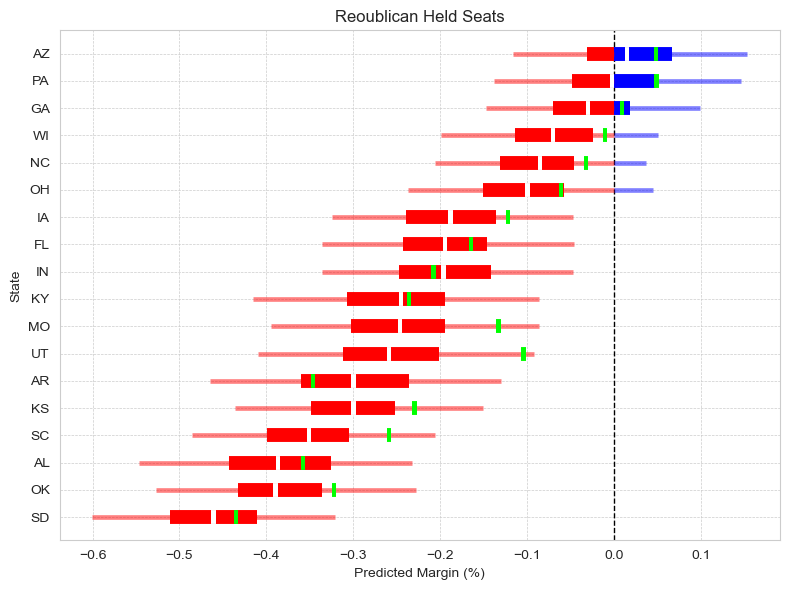

In [94]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('AL', 'AK', 'AZ', 'AR', 'FL', 'GA', 'ID', 'IN', 'IA', 'KS', 'KY', 'LA', 'MO', 'NE', 'NC', 'ND', 'OH', 'OK', 'OK-S', 'PA', 'SC', 'SD', 'UT', 'WI')").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(8, 6))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Reoublican Held Seats')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')

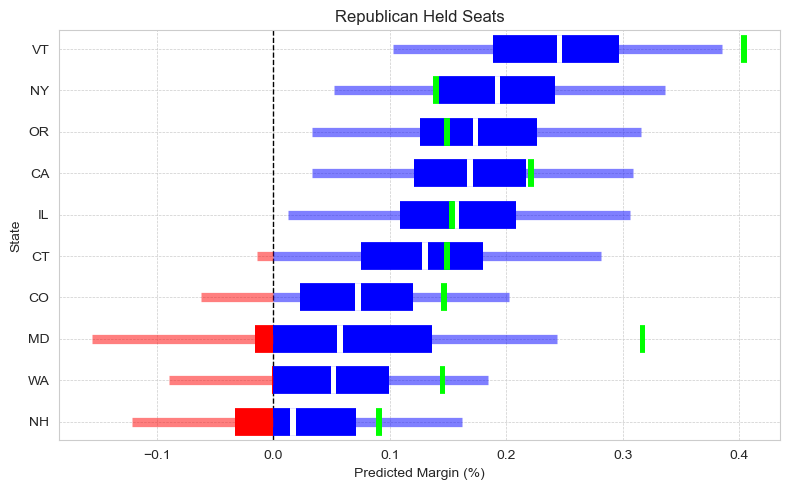

In [95]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('CA', 'CO', 'CT', 'HI', 'IL', 'MD', 'NH', 'NY', 'OR', 'VT', 'WA')").sort_values(by='hdi_mean')
scale_factor = 2

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Republican Held Seats')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')

In [96]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_senate[['dem_senate','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['generic_margin'] = df_dem.mean(axis=1) - df_gop.mean(axis=1)

grouped_df = df_winp.groupby(list(df_winp.columns[1:-1])).agg(
    count=('generic_margin', 'size'),   # Count the occurrences of each unique combination of rows
    generic_margin=('generic_margin', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)
grouped_df.to_excel('df_value_counts.xlsx', index=False)

In [97]:
df_winp

,AZ,NV,GA,WI,OH,IN,MO,CO,NH,OK,...,CT,VT,SD,MD,SC,KY,dem_senate,dem,gop,generic_margin
0,1,0,0,0,0,0,0,1,1,0,...,1,1,0,1,0,0,0,46,52,-0.063179
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,42,56,-0.107758
2,1,0,0,0,0,0,0,1,0,0,...,1,1,0,1,0,0,0,45,53,-0.067932
3,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,43,55,-0.075592
4,1,0,0,0,0,0,0,1,0,0,...,1,1,0,1,0,0,0,45,53,-0.064588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,1,0,0,0,1,1,0,...,1,1,0,0,0,0,0,49,49,-0.021637
996,0,0,0,0,0,0,0,1,0,0,...,1,1,0,1,0,0,0,44,54,-0.033444
997,1,1,1,1,1,1,0,1,1,0,...,1,1,0,1,0,0,1,53,45,0.032281
998,1,1,1,1,1,0,0,1,1,0,...,1,1,0,1,0,0,1,52,46,0.017111


/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/2984995915.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/2984995915.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


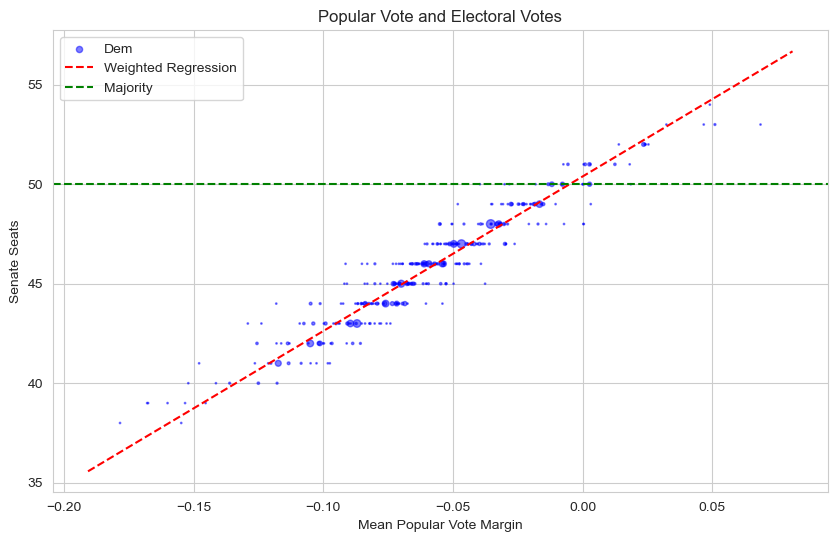

In [98]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(grouped_df['generic_margin'], grouped_df['dem'], 
            s=grouped_df['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = grouped_df['generic_margin']
y = grouped_df['dem']
weights = grouped_df['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

plt.axhline(y=50, color='green', linestyle='--', label='Majority')

# Add labels and title
plt.xlabel('Mean Popular Vote Margin')
plt.ylabel('Senate Seats')
plt.title('Popular Vote and Electoral Votes')

# Add legend
plt.legend()

# Show plot
plt.show()

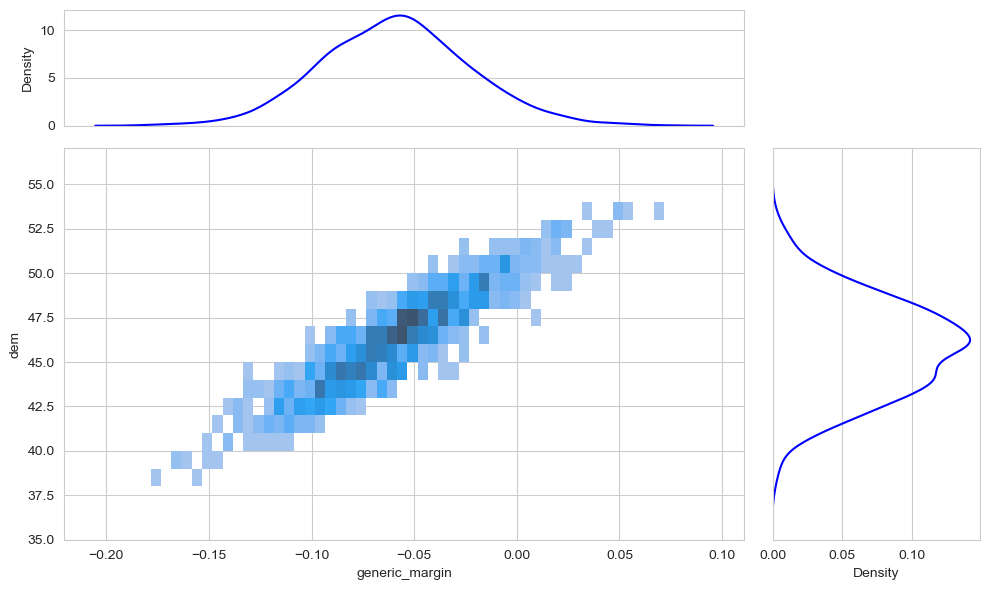

In [99]:
from matplotlib.gridspec import GridSpec

# Example Data (replace df_winp with your actual dataframe)
# df_winp = ...

# Create the figure with subplots
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 4, figure=fig)

# Main 2D histogram (place at center)
ax_main = fig.add_subplot(gs[1:4, 0:3])
sns.histplot(x=df_winp.generic_margin, y=df_winp.dem, binwidth=(.005,1), ax=ax_main)
#ax_main.axhline(y=306, color='green', linestyle='--', label='2020 Actual Result')
#ax_main.axvline(x=.0446, color='green', linestyle='--')

# KDE on top (for us_margin)
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
sns.kdeplot(x=df_winp.generic_margin, ax=ax_top, color='blue')
#ax_top.axvline(x=.0446, color='green', linestyle='--')  # Extend vertical dashed line to top KDE
ax_top.get_xaxis().set_visible(False)  # Hide x-axis labels

# KDE on the right (for dem)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
sns.kdeplot(y=df_winp.dem, ax=ax_right, color='blue')
#ax_right.axhline(y=306, color='green', linestyle='--')  # Extend horizontal dashed line to right KDE
ax_right.get_yaxis().set_visible(False)  # Hide y-axis labels

# Adjust layout
plt.tight_layout()

In [100]:
df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='state_code',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/2919227474.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = df_margin['margin'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/2919227474.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = df_margin['hdi_mean'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/2919227474.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

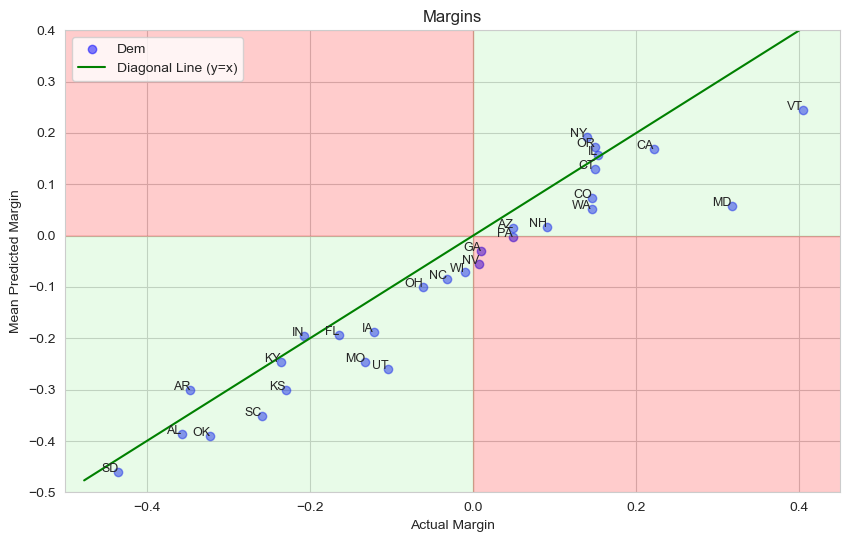

In [101]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.5, .45)
ax.set_ylim(-.5, .4)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.savefig('senate_2022_margins.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1624078446.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = df_margin['margin'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1624078446.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = df_margin['hdi_mean'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1624078446.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

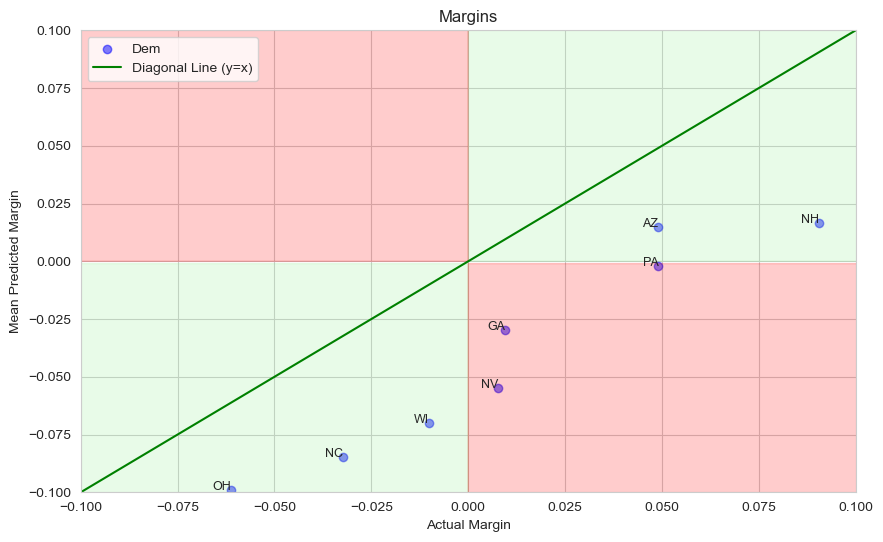

In [102]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.savefig('senate_2022_margins_zoom.png')

In [103]:
calc_slope = 1/slope
calc_intercept = intercept

In [104]:
calc_slope

0.012866670872135985

In [105]:
calc_intercept

50.39084491851261

In [106]:
df_margin['mean_corrected'] = df_margin.hdi_mean*calc_slope-calc_intercept
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1749889999.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1749889999.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1749889999.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

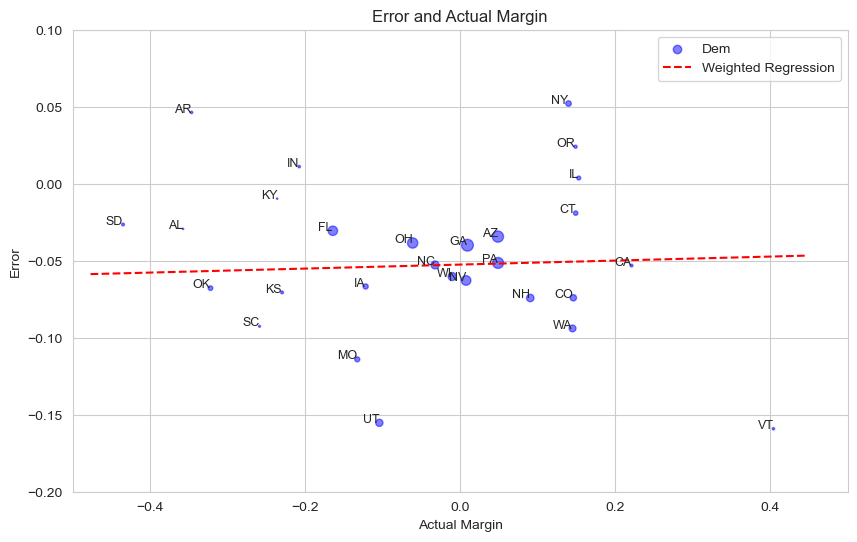

In [107]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .5)
ax.set_ylim(-.2, .1)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.savefig('senate_2022_error.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1733731390.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1733731390.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_43616/1733731390.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

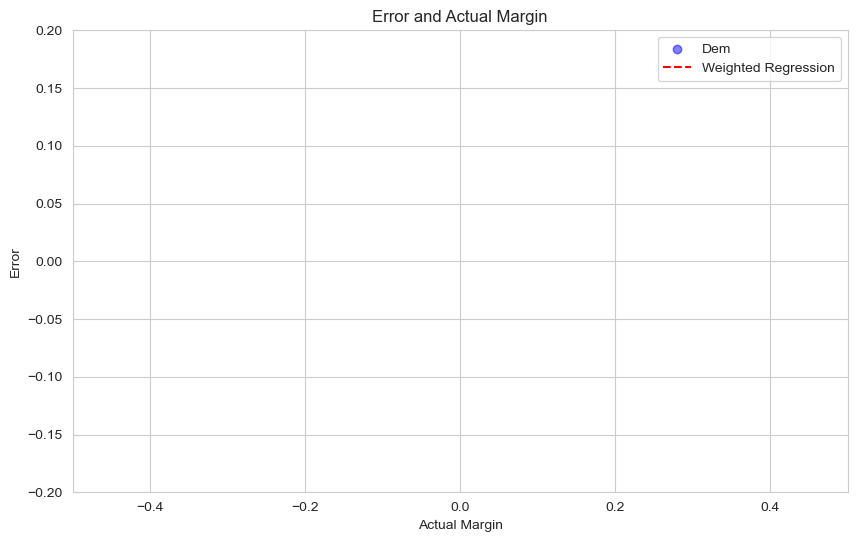

In [108]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error_corrected']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .5)
ax.set_ylim(-.2, .2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

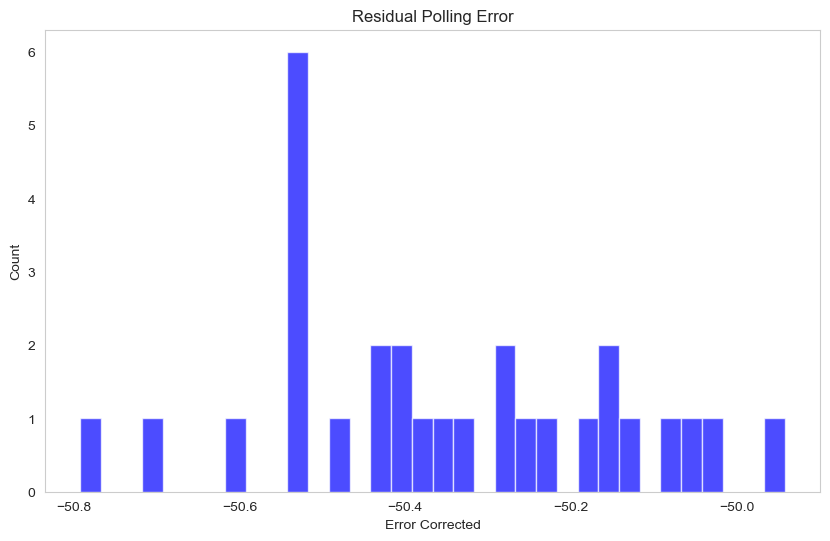

In [109]:
# Create the histogram
plt.figure(figsize=(10, 6))

bin_width = 0.025
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], bins=bins, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Error Corrected')
plt.ylabel('Count')
plt.title('Residual Polling Error')
plt.grid()

# Show the plot
plt.savefig('senate_2022_error_hist.png')